In [18]:
import VisionTransformer as vit

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Taxonomy of an inverse problem
Ongie, G., Jalal, A., Metzler, C. A., Baraniuk, R. G., Dimakis, A. G. & Willett, R. (2020). Deep Learning Techniques for Inverse Problems in Imaging. IEEE Journal on Selected Areas in Information Theory, 1(1), 39–56. https://doi.org/10.1109/jsait.2020.2991563

<h4><center>$y = A(x) + \epsilon$</center></h4>

- $y$: measurement (e.g. displacements)
- $x$: signal (e.g. traction forces)
- $A$: (non-linear) foward operator
- $\epsilon$: noise

__Goal__: recover $x$ from $y$

__Problem__: A is ill-posed, (matrix-) inversion is not possible


__Approach__: 
  1. Supervised: create a matched dataset by simulating the forward operator on clean data
  2. Train model to reconstruct signal by taking (corrupted) measurements as input
  3. Generalize to unseen measurements

## Comparison: CNN from Kratz et al. and ViT

In [4]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [12]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth')['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth', map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [13]:
cnn_weights = keras.models.load_model('../mltfm/models/model_noise_1e-4.h5')

In [14]:
dspl = h5py.File('data/displacements_25.h5')["data"]
trac = h5py.File('data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

In [61]:
pred_vit = vit_weights(X_test)
pred_cnn = cnn_weights.predict(dspl)

1/1 [==============================] - 1s 912ms/step


In [62]:
loss = torch.nn.MSELoss(reduction='none')
loss_vit = torch.sum(loss(pred_vit, Y_test), (1, 2, 3))
loss_cnn = torch.sum(loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test), (1, 2, 3))

loss_vit = torch.reshape(loss_vit, (25, 1))
loss_cnn = torch.reshape(loss_cnn, (25, 1))

In [63]:
pd.DataFrame(np.array(torch.cat((loss_vit, loss_cnn), 1).detach().numpy()), columns=['loss_ViT', 'loss_CNN'])

,loss_ViT,loss_CNN
0,2.754,0.953
1,4.902,2.071
2,2.240,0.820
3,2.466,1.020
4,3.119,1.172
5,4.251,1.810
6,2.809,1.016
7,5.284,2.160
8,3.905,1.641
9,6.274,2.362


<IPython.core.display.Javascript object>


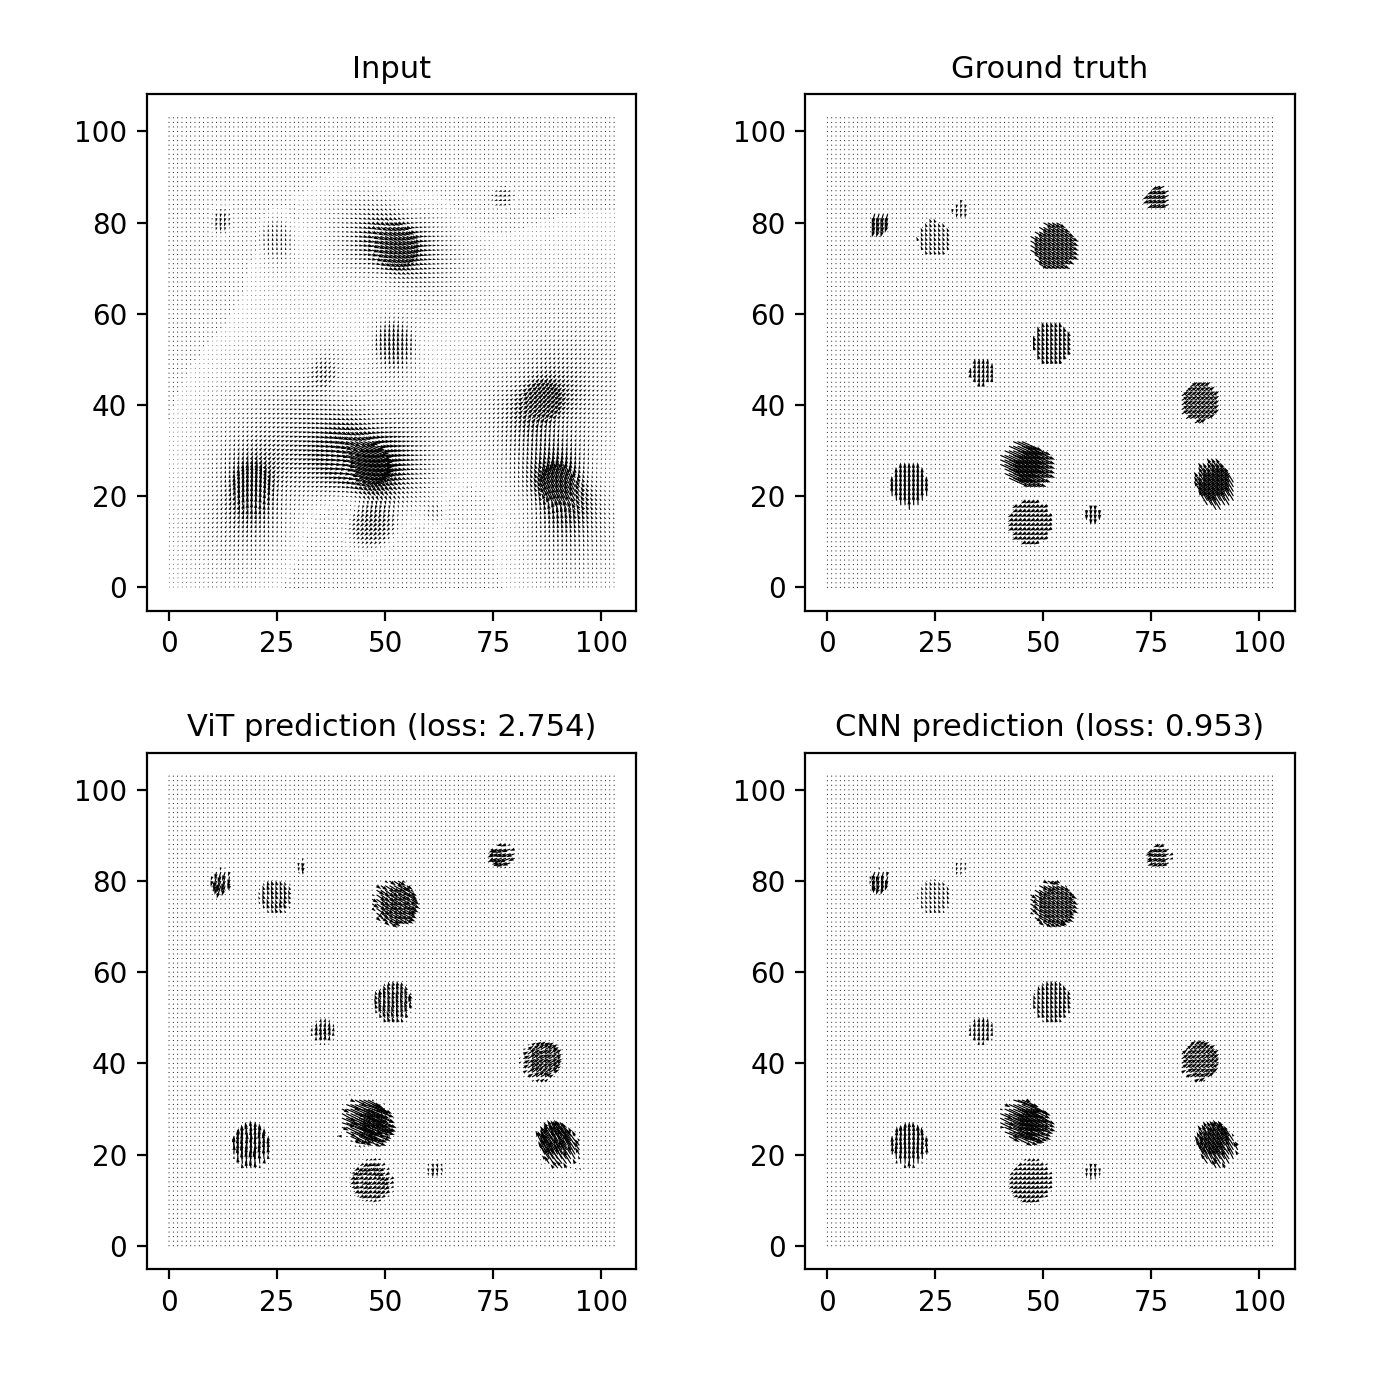

Text(0.5, 1.0, 'CNN prediction (loss: 0.953)')

In [68]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(7, 7))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

## Optimization possibilities

- Complexity of decoder (linear layer, FFNN, Convolutions, 'proper' decoder)
- Pretraining on low-resolution samples and finetuning on high resolution
- Multitask learning:
        - MSE
        - Classification: Split dataset in three groups, corrupt each group with Gaussian noise of different magnitude, infer label
        - Deviation of Traction Magnitude at Adhesions (DTMA)
        - Deviation of Traction Magnitude in the Background (DTMB)
        - Signal to Noise Ratio (SNR)
        - Deviation of Traction Direction at Adhesions (DDA)
- Hyperparameters: 
        - Depth of encoder/decoder
        - patch size
        - embedding dimension
        - number of attention heads
        - mlp ratio (number of hidden layers in MLP module)
        - dropout, attention dropout and stochastic path prob
        - weight initialization
        - optimizer
        - learning rate schedule
        - ... 